In [2]:
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.framework import ops
from tensorflow.python.training import optimizer
import tensorflow as tf
#import tflearn
import numpy as np
import pandas as pd

from optimizers import BayesAdam

import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
import _pickle as cPickle

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [5]:
def batches(X,Y, batchsize = 128):
    for i in range(0, len(X), batchsize):
        yield X[i:i + batchsize], Y[i:i + batchsize]

In [6]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(X, Y_),(X_test, Y_test_) = mnist.load_data()
X, X_test = X / 255.0, X_test / 255.0

In [7]:
X_train = X.reshape(X.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)

X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [8]:
import sklearn.preprocessing
label_binarizer = sklearn.preprocessing.LabelBinarizer()
label_binarizer.fit(range(max(Y_)+1))
Y_train = label_binarizer.transform(Y_)
label_binarizer.fit(range(max(Y_test_)+1))
Y_test = label_binarizer.transform(Y_test_)

In [9]:
Y_train.shape, Y_test.shape

((60000, 10), (10000, 10))

In [10]:
inds = np.random.permutation(X_train.shape[0])
# X_val = X_tmp[inds[:5000]]
# Y_val = Y_tmp[inds[:5000]]
X_train = X_train[inds]
Y_train = Y_train[inds]

In [11]:
#X_val.shape, Y_val.shape

In [12]:
X_train.shape, Y_train.shape

((60000, 784), (60000, 10))

In [13]:
def gaussian(x, mu, sigma):
    scaling = 1.0 / np.sqrt(2.0 * np.pi * (sigma ** 2))
    bell = np.exp(- (x - mu) ** 2 / (2.0 * sigma ** 2))

    return scaling * bell

def show_weight_dist(mean, variance):
    sigma = np.sqrt(variance)
    x = np.linspace(mean - 4*sigma, mean + 4*sigma, 100)
    plt.plot(x, gaussian(np.array(x), mean, sigma))
    plt.show()

In [16]:
def train(X, Y, X_test, Y_test, badam = True, num_epochs=10, learning_rate = 0.0001, l2 = 0.01, dropout= 0.0, 
          beta1=0.9, beta2=0.999, prec=100.0, laplace_mle=False, no_bias_init=False, size=60000, act='relu'):
    
    # learning_rate = 0.001 ## good for ~ 10-20 epochs
    # learning_rate = 0.0001 ## good for ~ 30-100 epochs
    
    
    cv_accuracy_results = []
    val_loss = []
    
    tf.reset_default_graph()
    tf.set_random_seed(1)
    
    inputs = tf.placeholder(tf.float32, [None, 784])
    labels = tf.placeholder(tf.int32, [None, 10])
    training = tf.placeholder(tf.bool, ())
    input_d = 784
    
    if act =='relu':
        act_fnc = tf.nn.relu
    elif act == 'sigmoid':
        act_fnc = tf.nn.sigmoid
    else:
        raise ValueError
    
    with tf.variable_scope('nn'):
        regularizer = tf.contrib.layers.l2_regularizer(scale=l2)
        _hidden = tf.layers.dense(inputs, 400, 
                                  kernel_initializer=tf.initializers.random_normal(mean=0.0, stddev=0.1, seed=None),
                                  bias_initializer=tf.initializers.random_normal(mean=0.0, stddev=0.1, seed=None),
                                  kernel_regularizer=regularizer,
                                  bias_regularizer=regularizer,
                                  name='dense_l1')
        hidden_d = tf.layers.dropout(_hidden, rate=dropout, training=training)
        hidden = act_fnc(hidden_d)
        
        _hidden = tf.layers.dense(hidden, 400, kernel_initializer=tf.initializers.random_normal(mean=0.0, stddev=0.1, seed=None),
                                  bias_initializer=tf.initializers.random_normal(mean=0.0, stddev=0.1, seed=None),
                                  kernel_regularizer=regularizer,
                                  bias_regularizer=regularizer,
                                  name='dense_l2')
        hidden_d = tf.layers.dropout(_hidden, rate=dropout, training=training)
        hidden = act_fnc(hidden_d)
        
        logits = tf.layers.dense(hidden, 10, kernel_initializer=tf.initializers.random_normal(mean=0.0, stddev=0.1, seed=None),
                                 bias_initializer=tf.initializers.random_normal(mean=0.0, stddev=0.1, seed=None),
                                 name='dense_out')
        out = tf.nn.softmax(logits)
        
    tmp = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits))
    loss = tmp + tf.losses.get_regularization_loss()
    opt = BayesAdam(learning_rate=learning_rate, N=size,
                    laplace_mle=laplace_mle, no_bias_init=no_bias_init,
                    params = {'beta_1': beta1, 
                              'beta_2': beta2,
                              'prec': prec})

    weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=tf.get_variable_scope().name)
    
    opt_train = opt.minimize(loss)
 
    correct_prediction = tf.equal(tf.argmax(out,1), tf.argmax(labels,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(num_epochs):

            i=0
            for x, y in batches(X,Y):
                sess.run(opt_train, {inputs: x, labels: y, training: True})
                
#                 if i <100:
#                     print(sess.run(weights[3]))
#                     xxx = opt.get_slot(weights[3], "sigma")
#                     print("sigma: {}".format(sess.run(xxx)))
#                     print("m: {}".format(sess.run(opt.get_slot(weights[3], "m"))))
#                     print("v: {}".format(sess.run(opt.get_slot(weights[3], "v"))))
                    
            acc, l = sess.run([accuracy, loss], {inputs: X_test,  labels: Y_test, training: False})       
            cv_accuracy_results.append(acc)
            val_loss.append(l)

            print('Epoch: {:>2}: Validation loss: {:>3.5f}, Validation accuracy: {:>3.5f}'.format(epoch, l, acc))
    
        sigmas = [opt.get_slot(v, "sigma") for v in weights] 
           
        # store flattened arrays:
        if laplace_mle:
            mean_coefs = [opt.get_slot(v, "mean_coef") for v in weights]
            weightvalues = np.hstack(np.array([sess.run(c).flatten() * sess.run(w).flatten() for c, w in zip(mean_coefs, weights)]))
        else:
            weightvalues = np.hstack(np.array([sess.run(w).flatten() for w in weights]))
        
        sqrtsigmavalues = np.hstack(np.array([sess.run(tf.sqrt(s)).flatten() for s in sigmas]))
        
        # store weights:
        _weights = [sess.run(w) for w in weights]
        
        def resetweights():
            for v,_v in zip(weights,_weights):
                v_t = state_ops.assign(v,tf.cast(_v, v.dtype))
                sess.run(v_t)
        
        def pruning(remove_pct, new = True):
            if new: 
                sorted_STN = np.sort(np.abs(weightvalues)/sqrtsigmavalues)
            else: 
                sorted_STN = np.sort(np.abs(weightvalues))
            cuttoff = sorted_STN[int(remove_pct*len(sorted_STN))]
            #print(weights[-1])
            #print(sess.run(weights[-1]))

            for v,s in zip(weights,sigmas):
                if new:
                    stn = tf.abs(v)/tf.sqrt(s)
                    mask = tf.greater_equal(stn,cuttoff)
                else:
                    mask = tf.greater_equal(tf.abs(v),cuttoff)
                #print(sess.run(mask))
                v_t = state_ops.assign(v,tf.multiply(v, tf.cast(mask, v.dtype)))
                sess.run(v_t)
            #print(sess.run(weights[-1]))  
            
            acc = sess.run(accuracy, {inputs: X_test, labels: Y_test, training:False})
            print("%.2f, %s" % (np.sum(sorted_STN<cuttoff)/len(sorted_STN),acc ))
            return acc
        
        xs = np.append(0.1 * np.array(range(10)), [0.95, 0.96, 0.97, 0.98, 0.99, 0.992, 0.995, 0.997, 0.999])
        ya = []
        print("Pruning smallest elements (baseline):")
        for pct in xs:
            ya.append(pruning(pct, new= False))
        
        yb = []
        resetweights()
        print("Pruning using signal-to-noise from Bayes:")
        for pct in xs:
            yb.append(pruning(pct, new= True))
        return xs, ya, yb, cv_accuracy_results, weightvalues, sqrtsigmavalues, val_loss

In [17]:
runs=1
xx = []
yy_aa = []
yy_bb = []
accs = []
ww = []
ss = []
for _ in range(runs):
    x, ya, yb, acc, weightvalues, sqrtsigmavalues, _ = train(X_train, Y_train,
                                                             X_test, Y_test,
                                                             num_epochs=200, 
                                                             learning_rate = 0.001, l2 = 0.0,
                                                             dropout= 0.2, beta2=0.999, laplace_mle=False, 
                                                             no_bias_init=False,
                                                             prec=1/(0.5**2), size=60000, 
                                                             act='sigmoid')
    xx.append(x)
    yy_aa.append(ya)
    yy_bb.append(yb)
    accs.append(acc)
    ww.append(weightvalues)
    ss.append(sqrtsigmavalues)

INFO:tensorflow:Scale of 0 disables regularizer.
Epoch:  0: Validation loss: 0.25939, Validation accuracy: 0.92270
Epoch:  1: Validation loss: 0.22893, Validation accuracy: 0.93130
Epoch:  2: Validation loss: 0.20958, Validation accuracy: 0.93720
Epoch:  3: Validation loss: 0.19105, Validation accuracy: 0.94220
Epoch:  4: Validation loss: 0.17505, Validation accuracy: 0.94670
Epoch:  5: Validation loss: 0.16339, Validation accuracy: 0.94950
Epoch:  6: Validation loss: 0.15100, Validation accuracy: 0.95390
Epoch:  7: Validation loss: 0.14123, Validation accuracy: 0.95720
Epoch:  8: Validation loss: 0.13186, Validation accuracy: 0.95950
Epoch:  9: Validation loss: 0.12968, Validation accuracy: 0.96120
Epoch: 10: Validation loss: 0.12321, Validation accuracy: 0.96280
Epoch: 11: Validation loss: 0.11626, Validation accuracy: 0.96490
Epoch: 12: Validation loss: 0.11864, Validation accuracy: 0.96420
Epoch: 13: Validation loss: 0.10674, Validation accuracy: 0.96760
Epoch: 14: Validation loss:

Epoch: 49: Validation loss: 0.08846, Validation accuracy: 0.97670
Epoch: 50: Validation loss: 0.08730, Validation accuracy: 0.97900
Epoch: 51: Validation loss: 0.07956, Validation accuracy: 0.97960
Epoch: 52: Validation loss: 0.08006, Validation accuracy: 0.97900
Epoch: 53: Validation loss: 0.08619, Validation accuracy: 0.97900
Epoch: 54: Validation loss: 0.08867, Validation accuracy: 0.97860
Epoch: 55: Validation loss: 0.08767, Validation accuracy: 0.97900
Epoch: 56: Validation loss: 0.09225, Validation accuracy: 0.97790
Epoch: 57: Validation loss: 0.08343, Validation accuracy: 0.97890
Epoch: 58: Validation loss: 0.08685, Validation accuracy: 0.97960
Epoch: 59: Validation loss: 0.10281, Validation accuracy: 0.97590
Epoch: 60: Validation loss: 0.09093, Validation accuracy: 0.97790
Epoch: 61: Validation loss: 0.09148, Validation accuracy: 0.97830
Epoch: 62: Validation loss: 0.08822, Validation accuracy: 0.97850
Epoch: 63: Validation loss: 0.08832, Validation accuracy: 0.97910
Epoch: 64:

Epoch: 173: Validation loss: 0.11461, Validation accuracy: 0.98100
Epoch: 174: Validation loss: 0.12407, Validation accuracy: 0.97980
Epoch: 175: Validation loss: 0.12596, Validation accuracy: 0.98020
Epoch: 176: Validation loss: 0.11093, Validation accuracy: 0.98130
Epoch: 177: Validation loss: 0.11323, Validation accuracy: 0.98150
Epoch: 178: Validation loss: 0.12516, Validation accuracy: 0.97900
Epoch: 179: Validation loss: 0.11838, Validation accuracy: 0.98140
Epoch: 180: Validation loss: 0.12092, Validation accuracy: 0.98150
Epoch: 181: Validation loss: 0.11630, Validation accuracy: 0.98200
Epoch: 182: Validation loss: 0.12878, Validation accuracy: 0.98080
Epoch: 183: Validation loss: 0.12916, Validation accuracy: 0.97960
Epoch: 184: Validation loss: 0.12557, Validation accuracy: 0.97990
Epoch: 185: Validation loss: 0.11492, Validation accuracy: 0.98080
Epoch: 186: Validation loss: 0.11970, Validation accuracy: 0.98150
Epoch: 187: Validation loss: 0.11987, Validation accuracy: 0.9

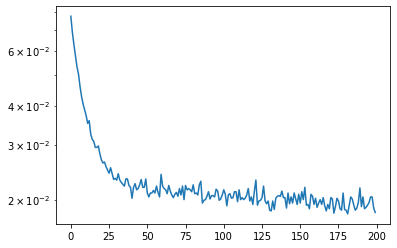

In [18]:
pd.Series(1-np.array(acc)).plot(logy=True)

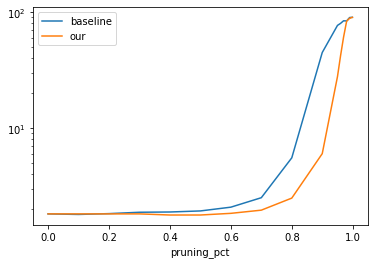

In [19]:
data = pd.DataFrame(pd.Series(x).rename('pruning_pct'))
data['baseline'] = 100*(1-np.array(ya))
data['our'] = 100*(1-np.array(yb))
data = data.set_index('pruning_pct')
data.plot(logy=True)

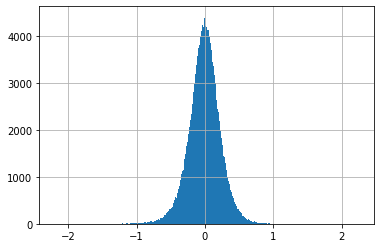

In [20]:
ax = pd.Series(weightvalues).hist(bins=1000)
#ax.set_xlim(-0.2, 0.2)

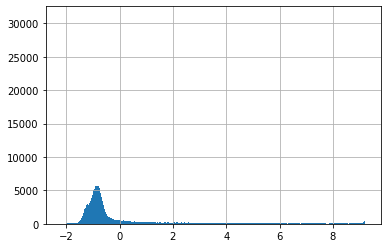

In [21]:
ax = pd.Series(np.log(sqrtsigmavalues)).hist(bins=1000)
#ax.set_xlim((0.00, 120))

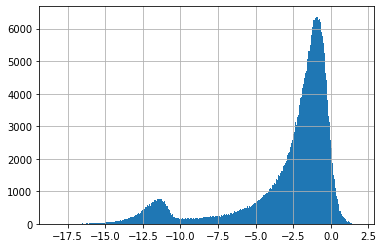

In [22]:
ax = pd.Series(np.log(np.abs(weightvalues)/sqrtsigmavalues + 1e-8)).hist(bins=500)
#ax.set_xlim((0.00, 1))

# Vanilla Adam

In [ ]:
def train_adam(X, Y, X_test, Y_test,
               num_epochs=10, learning_rate = 0.0001, dropout= 0.0, l2=0.0):
    
    # learning_rate = 0.001 ## good for ~ 10-20 epochs
    # learning_rate = 0.0001 ## good for ~ 30-100 epochs
    
    
    cv_accuracy_results = []
    
    tf.reset_default_graph()
    tf.set_random_seed(1)
    
    inputs = tf.placeholder(tf.float32, [None, 784])
    labels = tf.placeholder(tf.int32, [None, 10])
    training = tf.placeholder(tf.bool, ())
    input_d = 784
    
    with tf.variable_scope('nn'):
        regularizer = tf.contrib.layers.l2_regularizer(scale=l2)
        _hidden = tf.layers.dense(inputs, 400, 
                                  kernel_initializer=tf.initializers.random_normal(mean=0.0, stddev=0.1, seed=None),
                                  bias_initializer=tf.initializers.random_normal(mean=0.0, stddev=0.1, seed=None),
                                  kernel_regularizer=regularizer,
                                  bias_regularizer=regularizer,
                                  name='dense_l1')
        hidden_d = tf.layers.dropout(_hidden, rate=dropout, training=training)
        hidden = tf.nn.relu(hidden_d)
        
        _hidden = tf.layers.dense(hidden, 400, kernel_initializer=tf.initializers.random_normal(mean=0.0, stddev=0.1, seed=None),
                                  bias_initializer=tf.initializers.random_normal(mean=0.0, stddev=0.1, seed=None),
                                  kernel_regularizer=regularizer,
                                  bias_regularizer=regularizer,
                                  name='dense_l2')
        hidden_d = tf.layers.dropout(_hidden, rate=dropout, training=training)
        hidden = tf.nn.relu(hidden_d)
        
        logits = tf.layers.dense(hidden, 10, kernel_initializer=tf.initializers.random_normal(mean=0.0, stddev=0.1, seed=None),
                                 bias_initializer=tf.initializers.random_normal(mean=0.0, stddev=0.1, seed=None),
                                 name='dense_out')
        out = tf.nn.softmax(logits)
        
    tmp = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits))
    loss = tmp + tf.losses.get_regularization_loss()
    opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    opt_train = opt.minimize(loss)
 
    correct_prediction = tf.equal(tf.argmax(out,1), tf.argmax(labels,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(num_epochs):

            i=0
            for x, y in batches(X,Y):
                sess.run(opt_train, {inputs: x, labels: y, training: True})
                
#                 if i <100:
#                     print(sess.run(weights[3]))
#                     xxx = opt.get_slot(weights[3], "sigma")
#                     print("sigma: {}".format(sess.run(xxx)))
#                     print("m: {}".format(sess.run(opt.get_slot(weights[3], "m"))))
#                     print("v: {}".format(sess.run(opt.get_slot(weights[3], "v"))))
                    
                    
                i+=1
                if i%1000==0:
                    acc = sess.run(accuracy, {inputs: X_test,
                                 labels: Y_test})
                    cv_accuracy_results.append(acc)
            acc, l = sess.run([accuracy, loss], {inputs: X_test,  labels: Y_test, training: False})       
            cv_accuracy_results.append(acc)

            print('Epoch: {:>2}: Validation loss: {:>3.5f}, Validation accuracy: {:>3.5f}'.format(epoch, l, acc))
        
        
        weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=tf.get_variable_scope().name)
        
        # store flattened arrays:
        weightvalues = np.hstack(np.array([sess.run(w).flatten() for w in weights]))
                
        # store weights:
        _weights = [sess.run(w) for w in weights]
        
        def resetweights():
            for v,_v in zip(weights, _weights):
                v_t = state_ops.assign(v,tf.cast(_v, v.dtype))
                sess.run(v_t)
        
        def pruning(remove_pct):
            sorted_STN = np.sort(np.abs(weightvalues))
            cuttoff = sorted_STN[int(remove_pct*len(sorted_STN))]

            for v in weights:
                mask = tf.greater_equal(tf.abs(v),cuttoff)
                v_t = state_ops.assign(v,tf.multiply(v, tf.cast(mask, v.dtype)))
                sess.run(v_t)
            #print(sess.run(weights[-1]))  
            
            acc = sess.run(accuracy, {inputs: X_test, labels: Y_test, training:False})
            print("%.2f, %s" % (np.sum(sorted_STN<cuttoff)/len(sorted_STN),acc ))
            return acc
        
        xs = np.append(0.1 * np.array(range(10)), [0.95, 0.96, 0.97, 0.98, 0.99, 0.992, 0.995, 0.997, 0.999])
        ya = []
        print("Pruning smallest elements (baseline):")
        for pct in xs:
            ya.append(pruning(pct))
        
        resetweights()

        return xs, ya, cv_accuracy_results, weightvalues

In [ ]:
runs=1
xx = []
yy = []
accs = []
ww = []
for _ in range(runs):
    x, ya, acc, weightvalues = train_adam(X_train, Y_train, X_test, Y_test, 
                                          num_epochs=100, learning_rate = 0.001, dropout= 0.25, l2=0.0)
    xx.append(x)
    yy.append(ya)
    accs.append(acc)
    ww.append(weightvalues)

In [ ]:
pd.Series(1-np.array(accs[0])).plot(logy=True)

In [ ]:
data = pd.DataFrame(pd.Series(x).rename('pruning_pct'))
data['adam'] = 100*(1-np.array(ya))
#data['our'] = 100*(1-np.array(yb))
data = data.set_index('pruning_pct')
data.plot(logy=True)

In [ ]:
ax = pd.Series(weightvalues).hist(bins=500)